In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

In [2]:
df=pd.read_csv("TRADES_CopyTr_90D_ROI.csv")

In [3]:
df.head(10)

,Port_IDs,Trade_History
0,3925368433214965504,"[{'time': 1718899656000, 'symbol': 'SOLUSDT', ..."
1,4002413037164645377,"[{'time': 1718980078000, 'symbol': 'NEARUSDT',..."
2,3923766029921022977,"[{'time': 1718677164000, 'symbol': 'ETHUSDT', ..."
3,3994879592543698688,"[{'time': 1718678214000, 'symbol': 'ETHUSDT', ..."
4,3926423286576838657,"[{'time': 1718979615000, 'symbol': 'ETHUSDT', ..."
5,3987739404272887297,"[{'time': 1718979652000, 'symbol': 'ONDOUSDT',..."
6,4030395639953224449,"[{'time': 1718981481000, 'symbol': 'ETHUSDT', ..."
7,3953433416230728705,"[{'time': 1718942316000, 'symbol': 'BTCUSDT', ..."
8,3919174299855478272,"[{'time': 1718853879000, 'symbol': 'ETHUSDT', ..."
9,4029749871687083265,"[{'time': 1718675040000, 'symbol': 'FXSUSDT', ..."


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Port_IDs       150 non-null    int64 
 1   Trade_History  149 non-null    object
dtypes: int64(1), object(1)
memory usage: 2.5+ KB


In [5]:
import ast

In [6]:
# Drop missing trade history
df = df.dropna(subset=['Trade_History'])

# We have to convert JSON string into list
df['Trade_History'] = df['Trade_History'].apply(ast.literal_eval)

# Example of first trade
sample_trades = df['Trade_History'].iloc[0][:3]  
print(sample_trades)


[{'time': 1718899656000, 'symbol': 'SOLUSDT', 'side': 'BUY', 'price': 132.537, 'fee': -0.9940275, 'feeAsset': 'USDT', 'quantity': 1988.055, 'quantityAsset': 'USDT', 'realizedProfit': 0.0, 'realizedProfitAsset': 'USDT', 'baseAsset': 'SOL', 'qty': 15.0, 'positionSide': 'LONG', 'activeBuy': True}, {'time': 1718899618000, 'symbol': 'DOGEUSDT', 'side': 'BUY', 'price': 0.12182, 'fee': -0.27979617, 'feeAsset': 'USDT', 'quantity': 1398.98088, 'quantityAsset': 'USDT', 'realizedProfit': 0.0, 'realizedProfitAsset': 'USDT', 'baseAsset': 'DOGE', 'qty': 11484.0, 'positionSide': 'LONG', 'activeBuy': False}, {'time': 1718899618000, 'symbol': 'DOGEUSDT', 'side': 'BUY', 'price': 0.12182, 'fee': -0.03949404, 'feeAsset': 'USDT', 'quantity': 197.47022, 'quantityAsset': 'USDT', 'realizedProfit': 0.0, 'realizedProfitAsset': 'USDT', 'baseAsset': 'DOGE', 'qty': 1621.0, 'positionSide': 'LONG', 'activeBuy': False}]


In [7]:
trade_data = []

# Looping through each account and get all the trade details
for index, row in df.iterrows():
    for trade in row["Trade_History"]:
        trade["Port_ID"] = row["Port_IDs"]  #Using account ID simplify
        trade_data.append(trade)

# DataFrame of the data
trades_df = pd.DataFrame(trade_data)

print(trades_df.head())


            time    symbol side      price       fee feeAsset    quantity  \
0  1718899656000   SOLUSDT  BUY  132.53700 -0.994027     USDT  1988.05500   
1  1718899618000  DOGEUSDT  BUY    0.12182 -0.279796     USDT  1398.98088   
2  1718899618000  DOGEUSDT  BUY    0.12182 -0.039494     USDT   197.47022   
3  1718899616000  DOGEUSDT  BUY    0.12182 -0.008284     USDT    16.56752   
4  1718899616000  DOGEUSDT  BUY    0.12182 -0.046109     USDT    92.21774   

  quantityAsset  realizedProfit realizedProfitAsset baseAsset      qty  \
0          USDT             0.0                USDT       SOL     15.0   
1          USDT             0.0                USDT      DOGE  11484.0   
2          USDT             0.0                USDT      DOGE   1621.0   
3          USDT             0.0                USDT      DOGE    136.0   
4          USDT             0.0                USDT      DOGE    757.0   

  positionSide  activeBuy              Port_ID  
0         LONG       True  3925368433214965

In [8]:
#ROI
trades_df["investment"] = trades_df["quantity"] * trades_df["price"]
roi_per_account = trades_df.groupby("Port_ID").apply(lambda x: (x["realizedProfit"].sum() / x["investment"].sum()) * 100)


In [9]:
#PNL
pnl_per_account = trades_df.groupby("Port_ID")["realizedProfit"].sum()

In [10]:
def max_drawdown(profits):
    peak = np.maximum.accumulate(profits)
    drawdown = (profits - peak) / peak
    return drawdown.min()

# Compute MDD per account
mdd_per_account = trades_df.groupby("Port_ID")["realizedProfit"].apply(max_drawdown)

In [11]:
sharpe_per_account = trades_df.groupby("Port_ID")["realizedProfit"].apply(lambda x: x.mean() / x.std() if x.std() != 0 else 0)


In [12]:
trades_df["win"] = trades_df["realizedProfit"] > 0
win_rate_per_account = trades_df.groupby("Port_ID")["win"].mean() * 100
win_positions_per_account = trades_df.groupby("Port_ID")["win"].sum()


In [13]:
total_positions_per_account = trades_df.groupby("Port_ID")["realizedProfit"].count()


In [14]:
# we have to combine all metrics into a single DataFrame
ranked_df = pd.DataFrame({
    "PnL": pnl_per_account,
    "ROI": roi_per_account,
    "MDD": mdd_per_account,
#print("Still has Inf?", np.isinf(ranked_df).sum().sum())
#print("Still has NaN?", ranked_df.isna().sum().sum())

    "Sharpe": sharpe_per_account,
    "WinRate": win_rate_per_account,
    "WinPositions": win_positions_per_account,
    "TotalPositions": total_positions_per_account
}).reset_index()

In [16]:
# Check for infinity values
print("Has Inf Values:", np.isinf(ranked_df).sum())

# Check for NaN 
print("Has NaN Values:", ranked_df.isna().sum())

# Check for extremely large values (first try was showing error related to this)
print("Has Extremely Large Values?\n", (ranked_df > 1e12).sum())

Has Inf Values: Port_ID            0
PnL                0
ROI                0
MDD               13
Sharpe             0
WinRate            0
WinPositions       0
TotalPositions     0
dtype: int64
Has NaN Values: Port_ID           0
PnL               0
ROI               0
MDD               1
Sharpe            0
WinRate           0
WinPositions      0
TotalPositions    0
dtype: int64
Has Extremely Large Values?
 Port_ID           149
PnL                 0
ROI                 0
MDD                 0
Sharpe              0
WinRate             0
WinPositions        0
TotalPositions      0
dtype: int64


In [17]:
# Replace infinite values with NaN
ranked_df.replace([np.inf, -np.inf], np.nan, inplace=True)

# Fill NaN with 0
ranked_df.fillna(0, inplace=True)

# Cap extreme values (above 1e12, set them to a reasonable max)
max_threshold = 1e12
ranked_df = ranked_df.clip(lower=-max_threshold, upper=max_threshold)


In [18]:
# Ensure all values are finite
assert np.isfinite(ranked_df.values).all(), "There are still invalid values!"

print("Data is now clean and ready for normalization!")


Data is now clean and ready for normalization!


In [19]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

# Normalize only numeric columns
columns_to_normalize = ["PnL", "ROI", "Sharpe", "WinRate", "WinPositions", "TotalPositions"]
ranked_df[columns_to_normalize] = scaler.fit_transform(ranked_df[columns_to_normalize])

# Invert MDD (Higher MDD should mean lower rank)
ranked_df["MDD"] = 1 - scaler.fit_transform(ranked_df[["MDD"]])


In [20]:
# Define Weights
weights = {
    "PnL": 0.25,
    "ROI": 0.20,
    "Sharpe": 0.20,
    "MDD": 0.15,
    "WinRate": 0.10,
    "WinPositions": 0.05,
    "TotalPositions": 0.05
}

# Final Score
ranked_df["FinalScore"] = (
    ranked_df["PnL"] * weights["PnL"] +
    ranked_df["ROI"] * weights["ROI"] +
    ranked_df["Sharpe"] * weights["Sharpe"] +
    ranked_df["MDD"] * weights["MDD"] +
    ranked_df["WinRate"] * weights["WinRate"] +
    ranked_df["WinPositions"] * weights["WinPositions"] +
    ranked_df["TotalPositions"] * weights["TotalPositions"]
)

# Rank and Select Top 20
top_20_accounts = ranked_df.sort_values(by="FinalScore", ascending=False).head(20)

# Save to CSV
top_20_accounts.to_csv("top_20_accounts.csv", index=False)

In [25]:
# Load the top 20 accounts data (update the file path if needed)
top_20_df = pd.read_csv("top_20_accounts.csv")

# Display the first few rows
print(top_20_df.head(20))

          Port_ID       PnL       ROI       MDD    Sharpe   WinRate  \
0   1000000000000  1.000000  0.000044  0.073144  0.184159  0.410437   
1   1000000000000  0.175160  1.000000  0.005766  0.508167  0.495370   
2   1000000000000  0.651145  0.002776  0.009218  0.405607  0.651896   
3   1000000000000  0.340079  0.002568  0.005785  0.541433  0.974589   
4   1000000000000  0.172191  0.009581  0.010728  0.845473  0.542264   
5   1000000000000  0.204284  0.000044  1.000000  0.173191  0.662949   
6   1000000000000  0.359980  0.001093  0.018018  0.399265  0.764966   
7   1000000000000  0.236268  0.000049  0.006551  0.500737  0.570050   
8   1000000000000  0.152697  0.000120  0.007692  1.000000  0.726793   
9   1000000000000  0.180246  0.186127  0.005766  0.677803  0.806862   
10  1000000000000  0.175131  0.514328  0.005766  0.581819  0.405652   
11  1000000000000  0.162667  0.000044  0.005766  0.800487  0.889951   
12  1000000000000  0.174934  0.624835  0.005766  0.502089  0.118660   
13  10

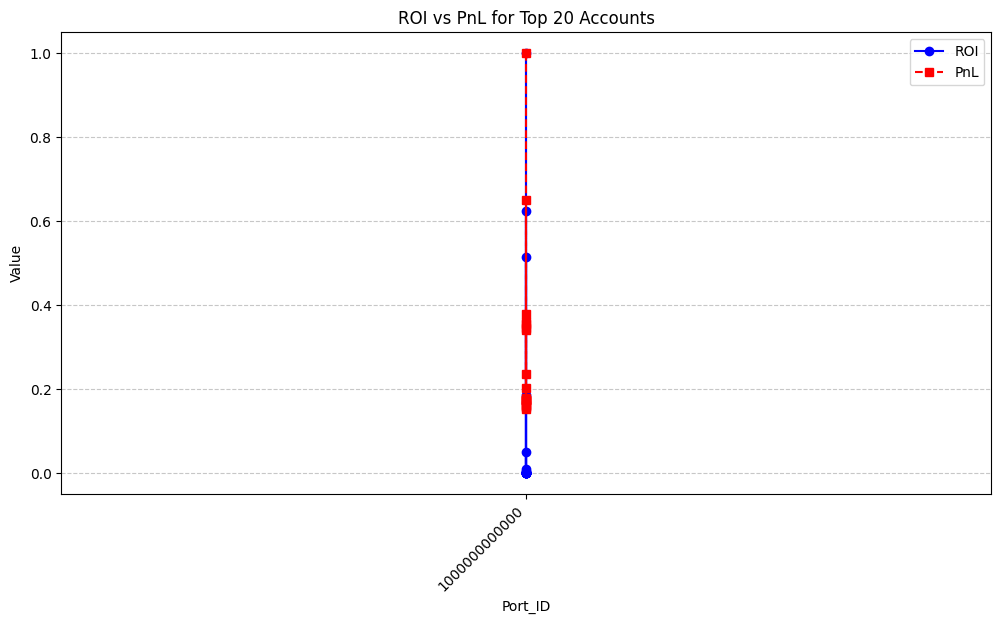

In [26]:
plt.figure(figsize=(12, 6))

# Plot ROI
plt.plot(top_20_df["Port_ID"].astype(str), top_20_df["ROI"], marker='o', linestyle='-', label="ROI", color='blue')

# Plot PnL
plt.plot(top_20_df["Port_ID"].astype(str), top_20_df["PnL"], marker='s', linestyle='--', label="PnL", color='red')

plt.xlabel("Port_ID")
plt.ylabel("Value")
plt.title("ROI vs PnL for Top 20 Accounts")
plt.xticks(rotation=45, ha="right")
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.7)

plt.show()
